___
# SEB Technical Assessment - Bartosz Piechnik

In [2]:
import pandas as pd
import numpy as np

from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

## Read Data

In [3]:
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('transactions.csv')
districts = pd.read_csv('districts.csv')

## Data Exploration

### Customers Summary

In [4]:
customers.head()

,CLIENT_ID,ACCOUNT_ID,GENDER,BIRTH_DT,ACTIVE,LOAN,DISTRICT_ID,SET_SPLIT
0,1,1,F,19701213,1,0.0,18,TRAIN
1,2,2,M,19450204,1,1.0,1,TRAIN
2,4,3,M,19561201,1,0.0,5,TEST
3,7,5,M,19290125,1,0.0,15,TRAIN
4,8,6,F,19380221,1,0.0,51,TRAIN


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4450 entries, 0 to 4449
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CLIENT_ID    4450 non-null   int64  
 1   ACCOUNT_ID   4450 non-null   int64  
 2   GENDER       4450 non-null   object 
 3   BIRTH_DT     4450 non-null   int64  
 4   ACTIVE       4450 non-null   int64  
 5   LOAN         4400 non-null   float64
 6   DISTRICT_ID  4450 non-null   int64  
 7   SET_SPLIT    4450 non-null   object 
dtypes: float64(1), int64(5), object(2)
memory usage: 278.2+ KB


### Transactions Summary

In [6]:
transactions.head()

,TRANS_ID,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
0,695247,2378.0,1011993,700.0,700.0,CREDIT,CREDIT_IN_CASH
1,171812,576.0,1011993,900.0,900.0,CREDIT,CREDIT_IN_CASH
2,207264,704.0,1011993,1000.0,1000.0,CREDIT,CREDIT_IN_CASH
3,1117247,3818.0,1011993,600.0,600.0,CREDIT,CREDIT_IN_CASH
4,579373,1972.0,2011993,400.0,400.0,CREDIT,CREDIT_IN_CASH


In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066320 entries, 0 to 1066319
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   TRANS_ID    1066320 non-null  int64  
 1   ACCOUNT_ID  1061320 non-null  float64
 2   DATE        1066320 non-null  int64  
 3   AMOUNT      1066320 non-null  float64
 4   BALANCE     1066320 non-null  float64
 5   TYPE        1066320 non-null  object 
 6   OPERATION   881436 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 56.9+ MB


### Districts Summary

In [8]:
districts.head()

,DISTRICT_ID,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
0,1,1204953,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,88884,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,75232,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,149893,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,95616,6,51.4,9307,3.85,4.43,118,2616,3040


In [9]:
districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DISTRICT_ID  77 non-null     int64  
 1   N_INHAB      77 non-null     int64  
 2   N_CITIES     77 non-null     int64  
 3   URBAN_RATIO  77 non-null     float64
 4   AVG_SALARY   77 non-null     int64  
 5   UNEMP_95     77 non-null     object 
 6   UNEMP_96     77 non-null     float64
 7   N_ENTR       77 non-null     int64  
 8   CRIME_95     77 non-null     object 
 9   CRIME_96     77 non-null     int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 6.1+ KB


## Data Clean-Up

### CUSTOMERS CLEAN-UP

#### CHECK IF ALL IDS IN `CLIENT_ID` ARE UNIQUE

In [10]:
customers['CLIENT_ID'].is_unique

True

#### CHECK IF ANY CLIENT HAS MORE THAN ONE ACCOUNT AND IF ANY ACCOUNT BELONGS TO MORE THAN ONE PERSON

In [11]:
client_customer_id = customers['CLIENT_ID'].astype(str) + '-' + customers['ACCOUNT_ID'].astype(str)

In [12]:
client_customer_id.is_unique

True

#### CHECK IF ALL VALUES IN `GENDER` COLUMNS ARE EITHER 'F' OR 'M'

In [13]:
customers.groupby('GENDER').count().axes[0].values.tolist() == ['F', 'M']

True

#### CONVERT DATE TO PANDAS' `DATETIME` FORMAT

In [14]:
customers['datetime'] = pd.to_datetime(customers['BIRTH_DT'], format="%Y%m%d")

In [15]:
customers['datetime'].head()

0   1970-12-13
1   1945-02-04
2   1956-12-01
3   1929-01-25
4   1938-02-21
Name: datetime, dtype: datetime64[ns]

#### CHECK FOR BIRTHDATE OUTLIERS

In [16]:
customers['today'] = pd.to_datetime(date.today().strftime('%Y%m%d'), format="%Y%m%d")

In [17]:
customers['age'] = (customers['today'] - customers['datetime']) / timedelta(days=365)

In [18]:
customers['age'] = np.floor(customers['age']).astype('int')

In [19]:
(customers['age'].max() < 120) & (customers['age'].min() >= 18)

True

#### CHECK IF ALL VALUES IN `SET_SPLIT` COLUMN ARE EITHER `TEST` OR `TRAIN`

In [20]:
customers.groupby('SET_SPLIT').count().axes[0].values.tolist() == ['TEST', 'TRAIN']

True

#### CHECK FOR `NULLS` IN THE `LOAN` COLUMN

In [21]:
customers[customers['LOAN'].isna()].head()

,CLIENT_ID,ACCOUNT_ID,GENDER,BIRTH_DT,ACTIVE,LOAN,DISTRICT_ID,SET_SPLIT,datetime,today,age
17,25,19,F,19390423,1,NaN,21,TEST,1939-04-23,2023-03-15,83
42,53,45,M,19770505,1,NaN,64,TRAIN,1977-05-05,2023-03-15,45
269,350,288,F,19250402,1,NaN,25,TRAIN,1925-04-02,2023-03-15,98
328,428,350,F,19191116,1,NaN,47,TEST,1919-11-16,2023-03-15,103
514,657,546,F,19260710,1,NaN,8,TEST,1926-07-10,2023-03-15,96


#### CONVERT 'NaN's TO ZEROS

Quick glance at the 'NaN' records suggests that these records represent legit accounts. Distribution betwen genders, district ID and enough randomness in date of birth indicate that these records are valid but miss the `LOAN` information.

Most of the birth dates for the customers with 'Nan' value are seniors (born before 1960). I will assume that these people became customers before loan product was offered by the bank. We don't need this distinction for our analysis, and since they are marked as '1' in `ACTIVE` column, I will assume that they are active customers without an active loan. Therefore I will convert all 'NaN's to zero.

Another hypothesis why certain records hold 'NaN' value is that data can come from a SQL database. In SQL 'Nan' values can be represented as 'Null'. 'Null' indicates state of 'unknown'. In our case, it would mean that we don't know if a customer has a loan or he hasn't. Since we can't be sure, we CAN'T mark it as zero (no loan). However, this situation seems extremely unlikely because we are dealing with bank data and assuming that a bank isn't aware of it's own loans is extremely unlikely. Therefore I will reject this hypothesis and update 'NaN' values to zeros.

In [22]:
customers['LOAN'] = customers['LOAN'].fillna(0)

In [23]:
customers['LOAN'].hasnans

False

#### CONVERT `LOAN` DATA TYPE FROM 'FLOAT' TO 'INT'

In [24]:
customers['LOAN'] = customers['LOAN'].astype('int')

In [25]:
customers['LOAN']

0       0
1       1
2       0
3       0
4       0
       ..
4445    0
4446    1
4447    1
4448    1
4449    0
Name: LOAN, Length: 4450, dtype: int32

#### REMOVE UNNEEDED COLUMNS

In [26]:
customers.drop(['BIRTH_DT', 'today', 'datetime'], axis=1, inplace=True)

#### SUMMARY - `Customers` TABLE AFTER CLEAN-UP

In [27]:
customers.head()

,CLIENT_ID,ACCOUNT_ID,GENDER,ACTIVE,LOAN,DISTRICT_ID,SET_SPLIT,age
0,1,1,F,1,0,18,TRAIN,52
1,2,2,M,1,1,1,TRAIN,78
2,4,3,M,1,0,5,TEST,66
3,7,5,M,1,0,15,TRAIN,94
4,8,6,F,1,0,51,TRAIN,85


### TRANSACTIONS CLEAN-UP

#### CHECK IF `TRANS_ID` VALUES ARE UNIQUE

In [28]:
transactions['TRANS_ID'].is_unique

False

#### INVESTIGATE DUPLICATES

In [29]:
transactions['TRANS_ID'].duplicated().groupby(transactions['TRANS_ID'].duplicated()).count()

TRANS_ID
False    1056320
True       10000
Name: TRANS_ID, dtype: int64

In [30]:
transactions[transactions.duplicated(keep=False)]

,TRANS_ID,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
132,612405,2087.0,29011993,16983.0,17583.0,CREDIT,CREDIT_IN_CASH
133,612405,2087.0,29011993,16983.0,17583.0,CREDIT,CREDIT_IN_CASH
136,796773,2714.0,30011993,800.0,800.0,CREDIT,CREDIT_IN_CASH
137,796773,2714.0,30011993,800.0,800.0,CREDIT,CREDIT_IN_CASH
245,542217,1844.0,7021993,3242.0,6996.6,CREDIT,COLLECTION_FROM_OTHER_BANK
...,...,...,...,...,...,...,...
1065787,3637054,3225.0,31121998,359.2,85171.9,CREDIT,NaN
1065795,3553434,696.0,31121998,234.8,56102.8,CREDIT,NaN
1065867,3471092,4526.0,31121998,281.5,83037.3,CREDIT,NaN
1065905,3457056,9707.0,31121998,272.0,99872.3,CREDIT,NaN


There are close to 5000 duplicate values. There should be no duplicate transactions in the table as each each `TRANS_ID` should be unique. I will remove the duplicates as the number of duplicates is very low (less than half percent of all transactions) and it seems like duplicates were added by mistake as previously mentioned.

#### REMOVE DUPLICATES

In [31]:
transactions.drop_duplicates('TRANS_ID', inplace=True)

In [32]:
transactions['TRANS_ID'].is_unique

True

#### CHECK FOR MISSING VALUES IN ACCOUNT_ID

In [33]:
transactions.isna().sum()

TRANS_ID           0
ACCOUNT_ID      4961
DATE               0
AMOUNT             0
BALANCE            0
TYPE               0
OPERATION     183114
dtype: int64

There are 5000 missing values in the `ACCOUNT_ID` column which is less than half percent of all transactions. The 'misising values' sample is homogenous as shown by the 'summary-describe()' tables. Ratios of "transactions in a particular category (eg. 'CC_WITHDRAWAL')" vs "total transactions" are very similar in both the sample and total population set. `ACCOUNT_ID` missing value can be a problem for certain types of future operations (eg. joins over tables) because database consistency is not maintained.

HOMOGENEITY CHECK

In [34]:
only_nulls = transactions.loc[transactions['ACCOUNT_ID'].isnull()]
full_set_without_nulls = transactions.dropna(subset='ACCOUNT_ID')

def homogeneity_check(dataset):
    
    grouped_set = dataset.groupby('OPERATION').count()
    grouped_set['ratio'] = grouped_set['TRANS_ID'] / dataset['TRANS_ID'].count()
    grouped_set['ratio'] = grouped_set['ratio'].map('{:.1%}'.format)
    
    return grouped_set[['ratio']].values.tolist()


only_nulls_summary = homogeneity_check(only_nulls)
full_set_without_nulls_summary = homogeneity_check(full_set_without_nulls)

print("Transactions set with no 'NaN's'",'\n', only_nulls_summary)
print("Transactions set with only 'Nan's",'\n', full_set_without_nulls_summary)

Transactions set with no 'NaN's' 
 [['0.5%'], ['6.8%'], ['15.0%'], ['18.9%'], ['41.6%']]
Transactions set with only 'Nan's 
 [['0.8%'], ['6.2%'], ['14.8%'], ['19.7%'], ['41.2%']]


We can see that the ratio values for each `OPERATION` category (eg. 'CREDIT_IN_CASH', 'COLLECTION_FROM_BANK', etc) are very similar in both sets. Therefore the sample set is homogenous with the population set. This gives us confidence to remove the 'NaN' values without a high risk of negatively influencing the results of further analysis.

In [35]:
transactions.dropna(subset='ACCOUNT_ID', inplace=True)

In [36]:
transactions.isna().sum()

TRANS_ID           0
ACCOUNT_ID         0
DATE               0
AMOUNT             0
BALANCE            0
TYPE               0
OPERATION     182262
dtype: int64

#### CHECK IF A COMBINATION OF TRANSACTION ID AND ACCOUNT IS UNIQUE

In [37]:
transactions_account_id = transactions['TRANS_ID'].astype(str) + '-' + transactions['ACCOUNT_ID'].astype(str)

In [38]:
transactions_account_id.is_unique

True

#### CHECK IF THERE ARE ANY 'NaN' VALUES IN ANY OTHER COLUMN

In [39]:
transactions.isna().sum()

TRANS_ID           0
ACCOUNT_ID         0
DATE               0
AMOUNT             0
BALANCE            0
TYPE               0
OPERATION     182262
dtype: int64

In [40]:
"{:.0%}".format(transactions.isna().sum()['OPERATION'] / len(transactions.index))

'17%'

There are 180k missing transactions with missing 'OPERATION' value which is 17% of total transactions. My hypothesis is that these belong to the sixth 'OPERATION' category. Most likely the missing category is 'CREDIT_TO_CC'. The rationale behind this hypothesis is that there are three types of transactions (Credit Card related, Cash related and Bank Transfer related). For the two of these categories: Cash and Bank Transfer, we can see both credit and debit type. However, for Credit Card category we can only see credit type. Therefore, most likely the missing values belong to Credit part of Credit Card category.



In [41]:
transactions.groupby('OPERATION', dropna=False).count()

,TRANS_ID,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE
OPERATION,,,,,,
CC_WITHDRAWAL,8011,8011,8011,8011,8011,8011
COLLECTION_FROM_OTHER_BANK,64888,64888,64888,64888,64888,64888
CREDIT_IN_CASH,156001,156001,156001,156001,156001,156001
REMITTANCE_TO_OTHER_BANK,207344,207344,207344,207344,207344,207344
WITHDRAWAL_IN_CASH,432853,432853,432853,432853,432853,432853
NaN,182262,182262,182262,182262,182262,182262


Another clue which led me to my hypothesis was mean transation amount accross different 'OPERATION' categories. Credit card transactions are generally of lower value than bank transfers and cash withdrawals/deposits in the bank. Summary statistics of the dataset confirm this: 'CC_WITHDRAVAL' category has the lowest value mean among the categories. And the data set which consists of 'NaN' values has the lowest mean among all categories. Which is another reason to believe that this dataset is really 'CREDIT_TO_CC' category.

In [42]:
transactions.groupby('OPERATION', dropna=False).mean(numeric_only=True)['AMOUNT'].astype('int').sort_values(ascending=False)

C:\Users\Bartosz\AppData\Local\Temp\ipykernel_25920\3429856163.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  transactions.groupby('OPERATION', dropna=False).mean()['AMOUNT'].astype('int').sort_values(ascending=False)


OPERATION
CREDIT_IN_CASH                15431
COLLECTION_FROM_OTHER_BANK    11972
WITHDRAWAL_IN_CASH             5378
REMITTANCE_TO_OTHER_BANK       3229
CC_WITHDRAWAL                  2261
NaN                             150
Name: AMOUNT, dtype: int32

Based on the reasons described above I'm going to replace 'Nan's with 'CREDIT_TO_CC' tag.

In [43]:
transactions['OPERATION'] = transactions['OPERATION'].map(lambda x: 'CC_CREDIT' if pd.isna(x) else x)

In [44]:
transactions.isna().sum()

TRANS_ID      0
ACCOUNT_ID    0
DATE          0
AMOUNT        0
BALANCE       0
TYPE          0
OPERATION     0
dtype: int64

#### **CHECK IF THERE ARE ANY TRANSACTIONS WITH ZERO VALUE**

In [45]:
len(transactions[transactions['AMOUNT'] == 0].index)

14

In [46]:
transactions[transactions['AMOUNT'] == 0]

,TRANS_ID,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
85511,3455961,8957.0,31081994,0.0,72681.7,WITHDRAWAL,WITHDRAWAL_IN_CASH
109954,3451376,5129.0,30111994,0.0,-388.7,WITHDRAWAL,WITHDRAWAL_IN_CASH
135617,3452231,5483.0,31011995,0.0,113.1,WITHDRAWAL,WITHDRAWAL_IN_CASH
483108,3456605,9337.0,31011997,0.0,8502.9,WITHDRAWAL,WITHDRAWAL_IN_CASH
486931,3510214,9337.0,31011997,0.0,8488.2,WITHDRAWAL,WITHDRAWAL_IN_CASH
589491,3451866,5369.0,30061997,0.0,603.9,WITHDRAWAL,WITHDRAWAL_IN_CASH
733542,3449658,3859.0,31121997,0.0,197.0,WITHDRAWAL,WITHDRAWAL_IN_CASH
777390,3446795,1475.0,31011998,0.0,694.3,WITHDRAWAL,WITHDRAWAL_IN_CASH
803365,3456218,9051.0,28021998,0.0,1367.1,CREDIT,CC_CREDIT
806666,3507085,9051.0,28021998,0.0,1367.1,CREDIT,CC_CREDIT


There are 14 transactions with 'zero' amount. Since they have no impact on the aggregate statistics of the remaining transactions, I'm going to remove them from the dataset. However, I will keep them as a separate table to investigate the reason for transactions with zero amount. They are probably some kind of systems' related transactions as all of them take place at the last day of the calendar month.

In [47]:
count_before = len(transactions.index)

In [48]:
transactions.drop(transactions[transactions.AMOUNT == 0].index, inplace=True)

In [49]:
(count_before - len(transactions.index)) == 14

True

#### CHECK TYPE COLUMN

In [50]:
transactions.groupby('TYPE').groups.keys()

dict_keys(['CREDIT', 'WITHDRAWAL'])

These two categories represent account inflows and outflows, therefore there is no need for signed transactions. I expect to see no negative amount records in the next check

#### CHECK IF THERE ARE ANY TRANSACTIONS WHERE 'AMOUNT' IS LOWER THAN 0

In [51]:
len(transactions[transactions['AMOUNT'] < 0].index) == 0

True

#### **CHECK FOR OUTLIERS IN TRANSACTION AMOUNT AND TRANSACTION BALANCE**

In [52]:
transactions['AMOUNT'].max()

87400.0

The highest transaction amount is 87 thousands, so nothing irregular here.

In [53]:
transactions['BALANCE'].max()

209637.0

In [54]:
transactions['BALANCE'].min()

-41125.7

Both maximum and minimum balance in all transactions is the range -42k to 210k so nothing unusual.

**FORMAT DATE TO BE MORE READABLE**

In [55]:
transactions['DATE'] = transactions['DATE'].map(lambda x: ('0' + str(x)) if (len(str(x)) == 7) else x)

In [56]:
transactions['DATE'] = pd.to_datetime(transactions['DATE'], format="%d%m%Y")

In [57]:
transactions['DATE'].head()

0   1993-01-01
1   1993-01-01
2   1993-01-01
3   1993-01-01
4   1993-01-02
Name: DATE, dtype: datetime64[ns]

### DISTRICTS CLEAN-UP

#### **CHECK IF THERE ARE ANY 'NaN' VALUES**

In [58]:
districts.isna().sum()

DISTRICT_ID    0
N_INHAB        0
N_CITIES       0
URBAN_RATIO    0
AVG_SALARY     0
UNEMP_95       0
UNEMP_96       0
N_ENTR         0
CRIME_95       0
CRIME_96       0
dtype: int64

#### **CHECK FOR OUTLIERS IN EACH CATEGORY**

In [59]:
def check_outliers(table):
    check = {}
    for i in table.columns.tolist():
        check[i] = [{'max': table[i].max()}, {'min': table[i].min()}]
    return check

check_outliers(districts)

{'DISTRICT_ID': [{'max': 77}, {'min': 1}],
 'N_INHAB': [{'max': 1204953}, {'min': 42821}],
 'N_CITIES': [{'max': 11}, {'min': 1}],
 'URBAN_RATIO': [{'max': 100.0}, {'min': 33.9}],
 'AVG_SALARY': [{'max': 12541}, {'min': 8110}],
 'UNEMP_95': [{'max': '?'}, {'min': '0.29'}],
 'UNEMP_96': [{'max': 9.4}, {'min': 0.43}],
 'N_ENTR': [{'max': 167}, {'min': 81}],
 'CRIME_95': [{'max': '?'}, {'min': '1003'}],
 'CRIME_96': [{'max': 99107}, {'min': 888}]}

All these numbers look reasonable for each category, and as a bonus we got to see that 'UNEMP_95' has some weird values: '?', which we are going to investigate futher.

#### FIND RECORDS WITH '?' VALUES IN COLUMNS `UNEMP_95` AND `CRIME_95`

In [60]:
districts[districts['UNEMP_95'] == '?']

,DISTRICT_ID,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
68,69,42821,3,48.4,8173,?,7.01,124,?,1358


In [61]:
districts[districts['CRIME_95'] == '?']

,DISTRICT_ID,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
68,69,42821,3,48.4,8173,?,7.01,124,?,1358


It's the same row in both column. It's the column with 'DISTRICT_ID' = 69.

We don't want to remove this row as this would break consistency among the table. If we ever wanted to join tables using 'DISTRICT_ID' key, we would be missing some relationships. Instead, we are are going to use avarage change in unemployment and crime between 1995 and 1996 for similar records and update the missing values using the mean. By similar we understand records who have close values in the following columns: 'N_INHAB', 'URBAN_RATION', 'AVG_SALARY', 'UNEMP_96' and 'CRIME_96'. This is going to be partially manual process, we will filter the data using only one column and try to fit to a subset of districts which look similar. Not very scientific but good enough for just one record.

In [62]:
districts[districts['DISTRICT_ID'] == 69]

,DISTRICT_ID,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
68,69,42821,3,48.4,8173,?,7.01,124,?,1358


In [63]:
similar_districts = districts[(districts['AVG_SALARY'] > 8000) & (districts['AVG_SALARY'] < 8300)]

In [64]:
similar_districts = similar_districts[similar_districts['DISTRICT_ID'] != 69]

In [65]:
similar_districts.head(50)

,DISTRICT_ID,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
16,17,74062,7,61.4,8114,2.38,2.62,119,1003,1181
43,44,105606,7,53.0,8254,2.79,3.76,97,2166,2325
48,49,75685,9,60.8,8208,1.89,2.26,155,1660,2123
49,50,102609,6,52.0,8187,4.83,5.45,94,2123,2134
52,53,107911,7,50.9,8240,2.53,3.56,99,1850,1903
62,63,86513,5,50.5,8288,3.79,4.52,110,1562,1460
66,67,106054,6,63.1,8110,5.77,6.55,109,3244,3079


We will use this subset to calculate the average change of employment between 1995 and 1996.

#### BROKEN UNEMPLOYMENT VALUE UPDATE

In [66]:
similar_districts['unemp_change'] = similar_districts['UNEMP_96'] - similar_districts['UNEMP_95'].astype('float')

In [67]:
mean_unemp_change = similar_districts['unemp_change'].mean()

We are going to update `DISTRICT_ID` 69, which is represented by Index 68 in the `districts` table

In [68]:
districts.at[68, 'UNEMP_95'] = districts.iloc[68]['UNEMP_96'] - mean_unemp_change

We are also going to update data type for the full column

In [69]:
districts['UNEMP_95'] = districts['UNEMP_95'].astype('float')

In [70]:
districts.iloc[68]

DISTRICT_ID          69
N_INHAB           42821
N_CITIES              3
URBAN_RATIO        48.4
AVG_SALARY         8173
UNEMP_95       6.332857
UNEMP_96           7.01
N_ENTR              124
CRIME_95              ?
CRIME_96           1358
Name: 68, dtype: object

And repeat the process for `CRIME_95` column

#### **CRIME VALUE UPDATE**

In [71]:
similar_districts['crime_change'] = similar_districts['CRIME_96'] - similar_districts['CRIME_95'].astype('float')

In [72]:
mean_crime_change = similar_districts['crime_change'].mean()

In [73]:
districts.at[68, 'CRIME_95'] = districts.iloc[68]['CRIME_96'] - mean_crime_change

In [74]:
districts['CRIME_95'] = districts['CRIME_95'].astype('int64')

In [75]:
districts.iloc[68]

DISTRICT_ID       69.000000
N_INHAB        42821.000000
N_CITIES           3.000000
URBAN_RATIO       48.400000
AVG_SALARY      8173.000000
UNEMP_95           6.332857
UNEMP_96           7.010000
N_ENTR           124.000000
CRIME_95        1272.000000
CRIME_96        1358.000000
Name: 68, dtype: float64

And finally, check all columns for outliers again.

In [76]:
check_outliers(districts)

{'DISTRICT_ID': [{'max': 77}, {'min': 1}],
 'N_INHAB': [{'max': 1204953}, {'min': 42821}],
 'N_CITIES': [{'max': 11}, {'min': 1}],
 'URBAN_RATIO': [{'max': 100.0}, {'min': 33.9}],
 'AVG_SALARY': [{'max': 12541}, {'min': 8110}],
 'UNEMP_95': [{'max': 7.34}, {'min': 0.29}],
 'UNEMP_96': [{'max': 9.4}, {'min': 0.43}],
 'N_ENTR': [{'max': 167}, {'min': 81}],
 'CRIME_95': [{'max': 85677}, {'min': 818}],
 'CRIME_96': [{'max': 99107}, {'min': 888}]}

## Data Analysis

In the 'Data Analysis' part I'm going to focus on the CRIME aspect of the data. We will seek to answer following questions:
- which districts have the highest crime rate?
- can available data tell us something about the reasons for increased crime in particular districts?
- can available data falsify any of the commonly held beliefs about reasons for increased crime?
- any potential future action points to acquire deeper understanding of crime factors

#### WHAT ARE THE TOP 3 DISTRICTS WITH THE HIGHEST CRIME INCIDENTS IN 1995 AND 1996?

In [77]:
districts[['DISTRICT_ID', 'CRIME_95']].sort_values(by='CRIME_95', ascending=False).head(3).style.hide(axis='index')

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [ ]:
districts[['DISTRICT_ID', 'CRIME_96']].sort_values(by='CRIME_96', ascending=False).head(3).style.hide(axis='index')

DISTRICT_ID,CRIME_96
1,99107
54,18696
74,18347


The top 3 spots have been taken by the same three districts: 1, 54 and 74 in both years.

Nominal values don't tell the whole story thought. In order to get a better perspective, we match up crime incidents with number of citizens living the a district and call it 'crime ratio'.

In [ ]:
districts['CRIME_RATIO95'] = districts['CRIME_95'] / districts['N_INHAB']
districts['CRIME_RATIO96'] = districts['CRIME_96'] / districts['N_INHAB']

In [ ]:
districts.sort_values(by='CRIME_RATIO95', ascending=False).head(5).style.format({'CRIME_RATIO95': '{:,.2%}'.format, 'CRIME_RATIO96': '{:,.2%}'.format})

,DISTRICT_ID,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96,CRIME_RATIO95,CRIME_RATIO96
0,1,1204953,1,100.000000,12541,0.290000,0.430000,167,85677,99107,7.11%,8.22%
73,74,323870,1,100.000000,10673,4.750000,5.440000,100,18782,18347,5.80%,5.66%
40,41,118650,3,85.600000,9832,3.320000,4.480000,114,6445,5471,5.43%,4.61%
39,40,128118,8,85.300000,9317,6.490000,7.070000,97,6949,6872,5.42%,5.36%
53,54,387570,1,100.000000,9897,1.600000,1.960000,140,18721,18696,4.83%,4.82%


When looking at the crime ratio, District 54 dropped of the podium to the fifth place, so we we will take the top 5 further.

There are few things which are pretty apparent on the first glance:
- all districts with highest crime have high population and are highly urbanized (80-100% range)
- unemployment seems to have little impact on the crime rate, districts with crime rate are districts in the low, medium and high enemployment categories nationwide
- higher average salary also seems to correlate with crime rate as all five districts have higher than average average salary (9031)

In [ ]:
districts['AVG_SALARY'].mean()

9031.675324675325

We will later see that these findings are confirmed by the correlation charts.

#### **CORRELATION CHARTS/SCATTERPLOTS**

In [ ]:
part_merge = pd.merge(transactions, customers, on='ACCOUNT_ID')

In [ ]:
full_merge = pd.merge(part_merge, districts, on='DISTRICT_ID')

#### UNEMPLOYMENT RATE

This is the most suprising/counter-intuitive finding of the analysis. It seems there is no linear-ascending relation between crime and unemployment. What's even more suprising, a district with the LOWEST UNEMPLOYMENT RATE has the HIGHEST CRIME RATE among districts.

<AxesSubplot: xlabel='UNEMP_95', ylabel='CRIME_RATIO95'>

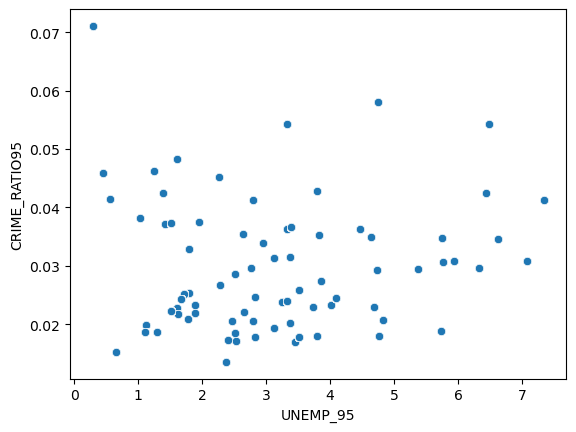

In [ ]:
sns.scatterplot(data=full_merge, x='UNEMP_95', y='CRIME_RATIO95')

In [ ]:
#sns.lmplot(data=full_merge, x='UNEMP_95', y='CRIME_RATIO95')

#### NUMBER OF INHABITANTS

Linear relation is pretty apparent on the charts. The more inhabitants in a district, the higher the crime rate.

<AxesSubplot: xlabel='N_INHAB', ylabel='CRIME_RATIO95'>

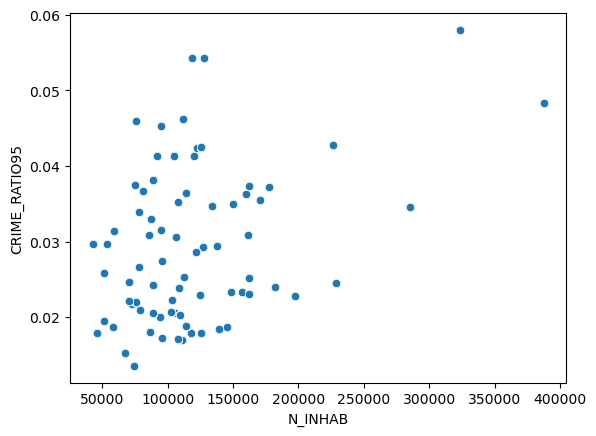

In [ ]:
sns.scatterplot(data=full_merge[full_merge['DISTRICT_ID'] != 1], x='N_INHAB', y='CRIME_RATIO95')

In [ ]:
#sns.lmplot(data=full_merge, x='N_INHAB', y='CRIME_RATIO95')

#### NUMBER OF CITIES

The charts are showing descending linear relation between number of cities and crime rate. It seems that the population density may influence that. Usually, a higher number of cities in a district means that the same number of people is more spread out. Larger number of cities with lower per city population correlates with a lower crime rate.

<AxesSubplot: xlabel='N_CITIES', ylabel='CRIME_RATIO95'>

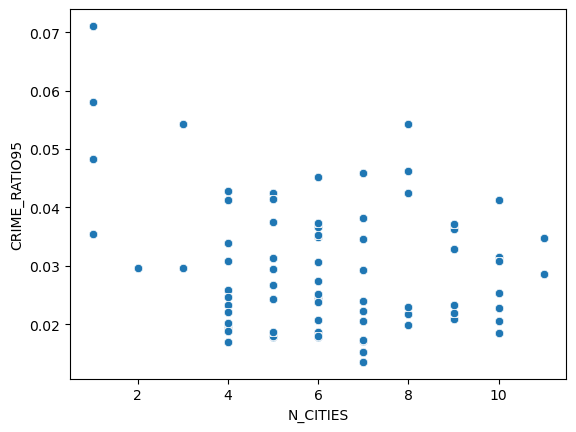

In [ ]:
sns.scatterplot(data=full_merge, x='N_CITIES', y='CRIME_RATIO95')

In [ ]:
#sns.lmplot(data=full_merge, x='N_CITIES', y='CRIME_RATIO95')

#### AVERAGE SALARY



This the highlight chart of the analysis as the linear relation is the most visible. The higher average salary in the district, the higher the crime rate.

<AxesSubplot: xlabel='AVG_SALARY', ylabel='CRIME_RATIO95'>

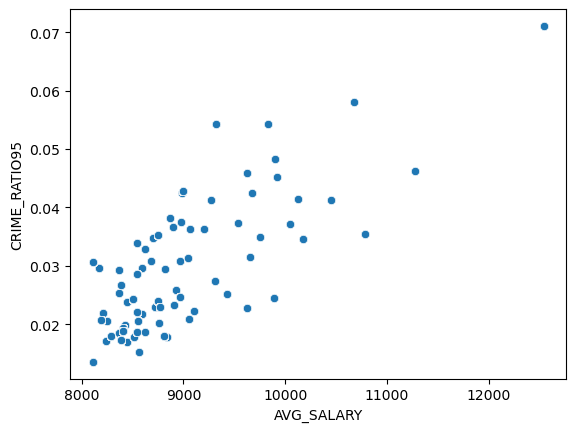

In [ ]:
sns.scatterplot(data=full_merge, x='AVG_SALARY', y='CRIME_RATIO95')

In [ ]:
#sns.lmplot(data=full_merge, x='AVG_SALARY', y='CRIME_RATIO95')

#### URBAN RATIO

Urban ratio can be understood as the opposite of number of cities. The higher the urbanization ratio, the higher concentration of population are living in the city, as opposed to the countryside. We can see that high urbanization rate is positively correlated with the crime rate.

<AxesSubplot: xlabel='URBAN_RATIO', ylabel='CRIME_RATIO95'>

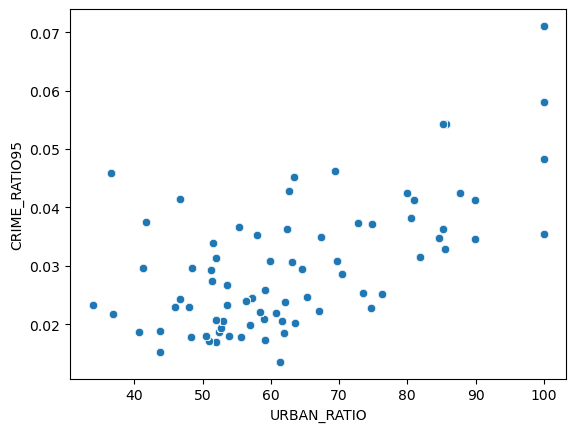

In [ ]:
sns.scatterplot(data=full_merge, x='URBAN_RATIO', y='CRIME_RATIO95')

In [ ]:
#sns.lmplot(data=full_merge, x='URBAN_RATIO', y='CRIME_RATIO95')

FINDINGS SUMMARY

- district with highest crime ratio (nr of crime incidents / districts population) is District 1, most likely Stockholm
- high crime ratio is correlated with high population, high population density and high average salary
- contrary to common intuition, there is no correlation between crime rate and unemployment rate

## Logistic Regression

In this part, we are going to use logistic regression to try to predict whethere a customer has or hasn't got a loan with a bank. We are going to combine all three tables together and make sure that each column which was included in the merged table can be used by the logistic regression model.

#### MERGE CUSTOMERS AND DISTRICTS TABLE

In [ ]:
lr_part_merge = pd.merge(customers, districts, on='DISTRICT_ID')

#### ONE MORE FEATURE

To make data from `transactions` usable in the model, I will calculate the average balance accross all transaction per customer and add it to the data set.

In [ ]:
mean_balance = transactions.groupby('ACCOUNT_ID').mean()

In [ ]:
lr_full_merge = pd.merge(lr_part_merge, mean_balance, on='ACCOUNT_ID')

#### FILTER OUT ALL COLUMNS WHICH CAN'T BE USEFUL IN THE MODEL

In [ ]:
lr_ready = lr_full_merge[['GENDER', 'LOAN', 'age', 'N_INHAB', 'N_CITIES', 'URBAN_RATIO', 'AVG_SALARY', 'UNEMP_95', 'UNEMP_96', 'N_ENTR', 'CRIME_95', 'CRIME_96', 'CRIME_RATIO95', 'CRIME_RATIO96', 'BALANCE', 'SET_SPLIT']]

#### CONVERT CATEGORICAL DATA TO NUMERICAL

In [ ]:
lr_ready['GENDER'] = lr_ready['GENDER'].map({'M': 1, 'F': 0})

C:\Users\Bartosz\AppData\Local\Temp\ipykernel_22752\1391706578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_ready['GENDER'] = lr_ready['GENDER'].map({'M': 1, 'F': 0})


In [ ]:
#log_full_merge_for_log = log_full_merge_for_log.loc[:, log_full_merge_for_log.columns != 'DISTRICT_ID']

#### SPLIT DATA TO X AND Y VALUES

In [ ]:
X = lr_ready[['GENDER', 'age', 'N_INHAB', 'N_CITIES', 'URBAN_RATIO', 'AVG_SALARY', 'UNEMP_95', 'UNEMP_96', 'N_ENTR', 'CRIME_95', 'CRIME_96', 'CRIME_RATIO95', 'CRIME_RATIO96', 'BALANCE']]
y = lr_ready['LOAN']

#### SPLIT DATA X AND Y SETS INTO TRAIN AND TEST SETS

In [ ]:
X_train = lr_ready[lr_ready['SET_SPLIT'] == 'TRAIN'].drop(['SET_SPLIT', 'LOAN'], axis=1)
X_test = lr_ready[lr_ready['SET_SPLIT'] == 'TEST'].drop(['SET_SPLIT','LOAN'], axis=1)
y_train = lr_ready[lr_ready['SET_SPLIT'] == 'TRAIN']['LOAN']
y_test = lr_ready[lr_ready['SET_SPLIT'] == 'TEST']['LOAN']

#### TRAIN THE MODEL

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

#### PREDICTIONS AND EVALUATIONS

In [ ]:
predictions = logmodel.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       758
           1       1.00      0.01      0.02       131

    accuracy                           0.85       889
   macro avg       0.93      0.50      0.47       889
weighted avg       0.88      0.85      0.79       889



In [ ]:
confusion_matrix(y_test, predictions)

array([[758,   0],
       [130,   1]], dtype=int64)

#### CONCLUSIONS

Train data set is disbalanced (85% '0' vs 15% '1'). Logistic regression don't perform well with disbalanced sets, which is apparent in the recall for 1s. Only 1% of true negatives were predicted (model marked almost all items as '0'). Possible improvements for the model include: use resampling methods (undersample 'no loans' set or oversample the 'loans' set). Another recommendation is to use algorithms which perform better on unbalanced sets like Support Vector Machine or Random Forest.